In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
import json
from timebudget import timebudget
from tqdm import tqdm
from os.path import isfile
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = './refactor/data/proc/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
E_names_file = './refactor/data/proc/E_names.json'

O = sio.loadmat(origdata_pth,squeeze_me=True)
O['E_dat']=np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
O['E_names']=np.concatenate([O['pc_name'],O['feature_name']],axis = 0)
with open(E_names_file) as f:
    temp = json.load(f)
O['E_names'] = np.array([temp[i] for i in O['E_names']])


#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
aug = 1
fiton='zT'
n_cvfolds = 43
        
CVdict={}
key_list = ['XrT','XrT_from_XE','XrE','XrE_from_XT','train_ind','val_ind','test_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                '_ri_0-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    if isfile(representation_pth+cvfold_fname): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 43/43 [00:09<00:00,  4.39it/s]


Differentially expressed genes for internal nodes:
- 109 : Pvalb
-  90 : Sst
-  63 : Vip
-  76 : Lamp5+Sncg


In [3]:
G = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/DE_gene_dict.mat',squeeze_me=True)
L = np.concatenate([G['n109'],G['n90'],G['n63'],G['n76']])
L = L.tolist()
L = [x.lstrip() for x in L]
L = [x.rstrip() for x in L]
len(L)

80

In [4]:
npp_genes = ['Vip','Npy','Sst','Penk','Tac2','Cck','Crh',
             'Tac1','Pdyn','Cort','Pthlh','Pnoc','Adcyap1',
             'Trh','Grp','Nmb','Nts','Rln1','Vipr1','Vipr2',
             'Npy1r','Npy2r','Npy5r','Sstr1','Sstr2',
             'Sstr3','Sstr4','Oprd1','Oprm1','Tacr3',
             'Cckbr','Crhr1','Crhr2','Tacr1','Oprk1',
             'Pth1r','Oprl1','Adcyap1r1','Trhr','Trhr2',
             'Grpr','Nmbr','Ntsr1','Ntsr2','Rxfp1','Rxfp2',
             'Rxfp3']

gene_list = npp_genes
#gene_list = L

#Find location of all genes
gene_inds = []
for gene in gene_list:
    ind = np.flatnonzero(np.isin(O['gene_id'],gene))
    if ind.size==1:
        gene_inds.append(ind[0])
gene_inds = np.array(gene_inds)
genes_found = O['gene_id'][gene_inds].tolist()

In [5]:
not_found=list(set(gene_list)-set(genes_found))
print(f'{len(not_found)} genes not found among genes used as autoencoder input')
not_found

11 genes not found among genes used as autoencoder input


['Grpr',
 'Rxfp2',
 'Oprk1',
 'Trh',
 'Sstr3',
 'Vipr2',
 'Nmb',
 'Tacr3',
 'Ntsr2',
 'Pth1r',
 'Trhr2']

In [6]:
csTE = '1-0'
aE = '1-0'

cv_list = CVdict.keys()
XrT = np.concatenate([CVdict[cv]['XrT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrT_from_XE = np.concatenate([CVdict[cv]['XrT_from_XE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE = np.concatenate([CVdict[cv]['XrE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE_from_XT = np.concatenate([CVdict[cv]['XrE_from_XT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)

val_ind = np.concatenate([CVdict[cv]['val_ind'] for cv in cv_list],axis=0)

### T reconstruction $R^2$

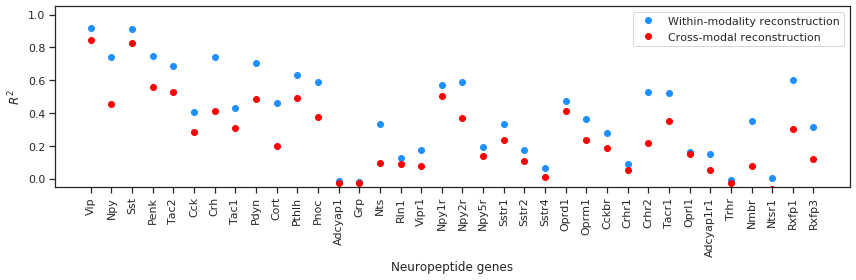

In [7]:
R2_T_to_T = 1 - np.mean((O['T_dat'][val_ind,:] - XrT)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)
R2_E_to_T = 1 - np.mean((O['T_dat'][val_ind,:] - XrT_from_XE)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)

fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(len(genes_found)), R2_T_to_T[gene_inds],'o',color='dodgerblue',label='Within-modality reconstruction')
plt.plot(np.arange(len(genes_found)), R2_E_to_T[gene_inds],'o',color='red',label='Cross-modal reconstruction')
plt.legend()
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_xlabel('Neuropeptide genes')
ax.set_ylim(-0.05,1.05)
ax.set_xticks(np.arange(len(genes_found)))
ax.set_xticklabels(genes_found,rotation=90)
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/R2_NPP_genes.png',dpi=300)

### E reconstruction $R^2$

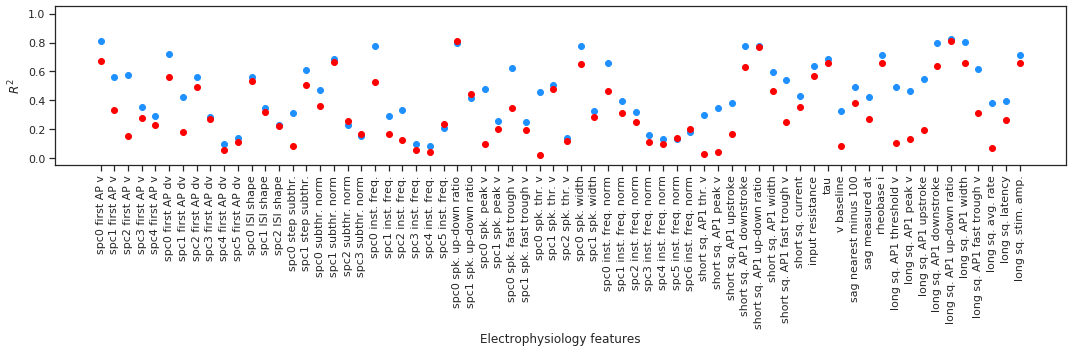

In [8]:
R2_E_to_E = 1 - np.nanmean((O['E_dat'][val_ind,:] - XrE)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)
R2_T_to_E = 1 - np.nanmean((O['E_dat'][val_ind,:] - XrE_from_XT)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(O['E_names'].size), R2_E_to_E[:],'o',color='dodgerblue',label='within-modality reconstruction')
plt.plot(np.arange(O['E_names'].size), R2_T_to_E[:],'o',color='red',label='Cross-modal reconstruction')
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_ylim(-0.05,1.05)
ax.set_xlabel("Electrophysiology features")
ax.set_xticks(np.arange(O['E_names'].size))
ax.set_xticklabels(O['E_names'],rotation=90)
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/R2_E_features.png',dpi=300)
plt.show()

In [9]:
#Get ordered list of well-sampled t-types
from refactor.utils.tree_helpers import get_merged_ordered_classes
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                   htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
                                                   n_required_classes=n_required_classes)

A = pd.DataFrame(pd.Series(O['cluster']).value_counts(),columns={'counts'})
well_sampled_types = A.loc[A['counts']>10].index.values
t_types = [t for t in t_types if t in well_sampled_types]

Performed 0 merges. Remaining classes in data = 59


**T cross modal data type wise**

In [10]:
true_vals = []
pred_vals = []

for t in t_types:
    this_type = t_type_labels[val_ind]==t
    true_vals.append(np.mean(O['T_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.mean(XrT_from_XE[this_type,:],axis=0))
    
true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)

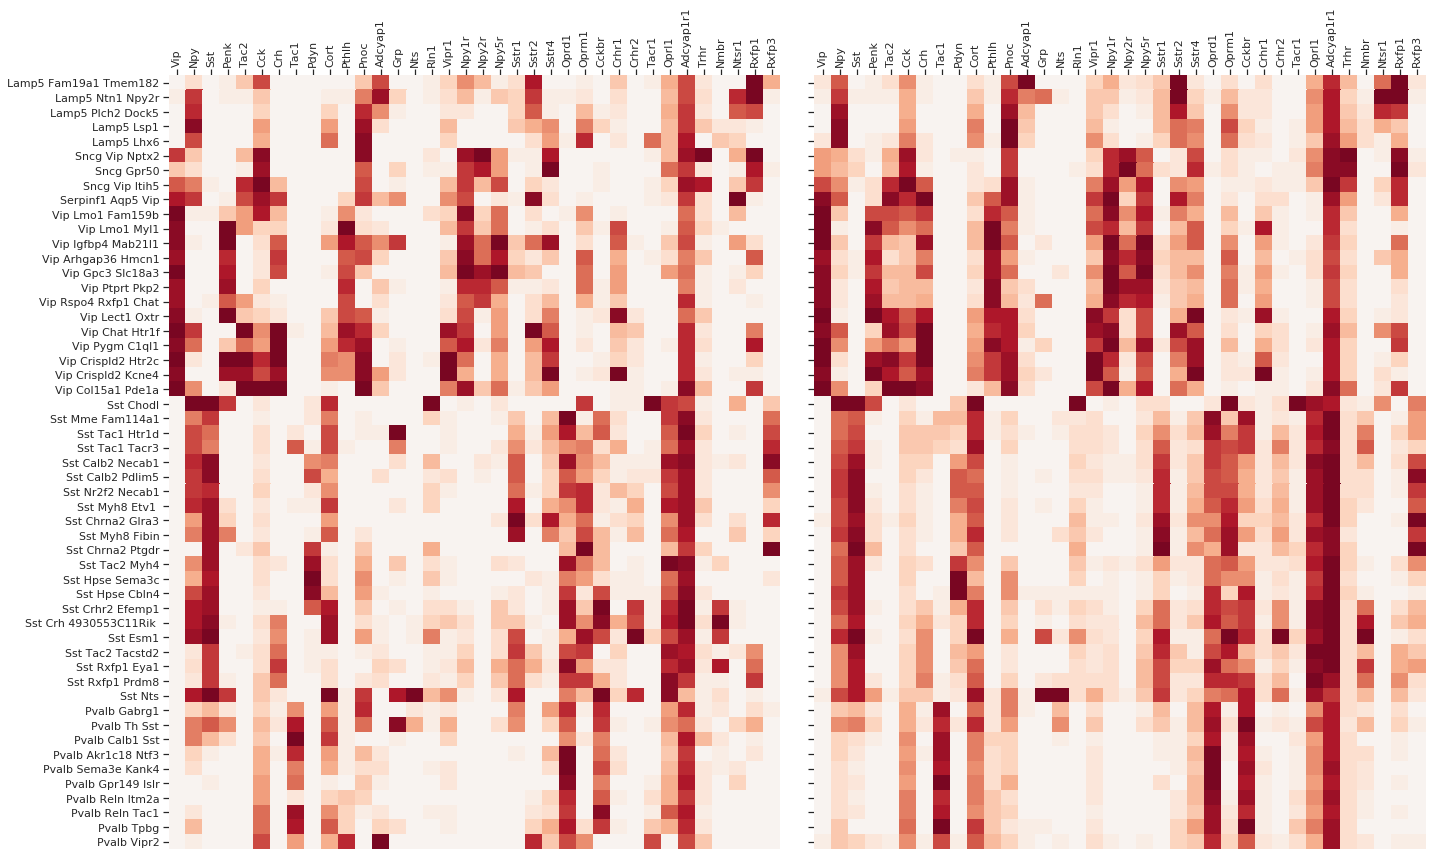

In [11]:
M_true = true_vals[:,gene_inds]/np.max(true_vals[:,gene_inds],axis=0)
M_pred = pred_vals[:,gene_inds]/np.max(pred_vals[:,gene_inds],axis=0)
xlabels = genes_found
ylabels = t_types

plt.figure(figsize = (20,12))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)

ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(['    ']*len(ylabels),rotation=0)

ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()

plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/T_dat_pred.png',dpi=300)

In [12]:
Pearson_R_per_type_E_to_T = []
for i in range(M_true.shape[0]):
    C_ij = np.corrcoef(M_true[i,:],M_pred[i,:])
    Pearson_R_per_type_E_to_T.append(C_ij[0,1])
print(f'Pearson r per type mean: {np.mean(Pearson_R_per_type_E_to_T):0.2f} sd: {np.std(Pearson_R_per_type_E_to_T):0.2f}')
print()

Pearson r per type mean: 0.89 sd: 0.10



**E cross modal data type wise**

In [13]:
true_vals = []
pred_vals = []
for t in t_types:
    this_type = t_type_labels[val_ind]==t
    true_vals.append(np.nanmean(O['E_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.nanmean(XrE_from_XT[this_type,:],axis=0))

true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)       
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)    

In [14]:
#Threshold chosen to match number of genes in the previous plot
keep_feature_ind = R2_E_to_E>0.42
M_true = true_vals[:,keep_feature_ind]/np.max(np.abs(true_vals[:,keep_feature_ind]),axis=0)
M_pred = pred_vals[:,keep_feature_ind]/np.max(np.abs(pred_vals[:,keep_feature_ind]),axis=0)

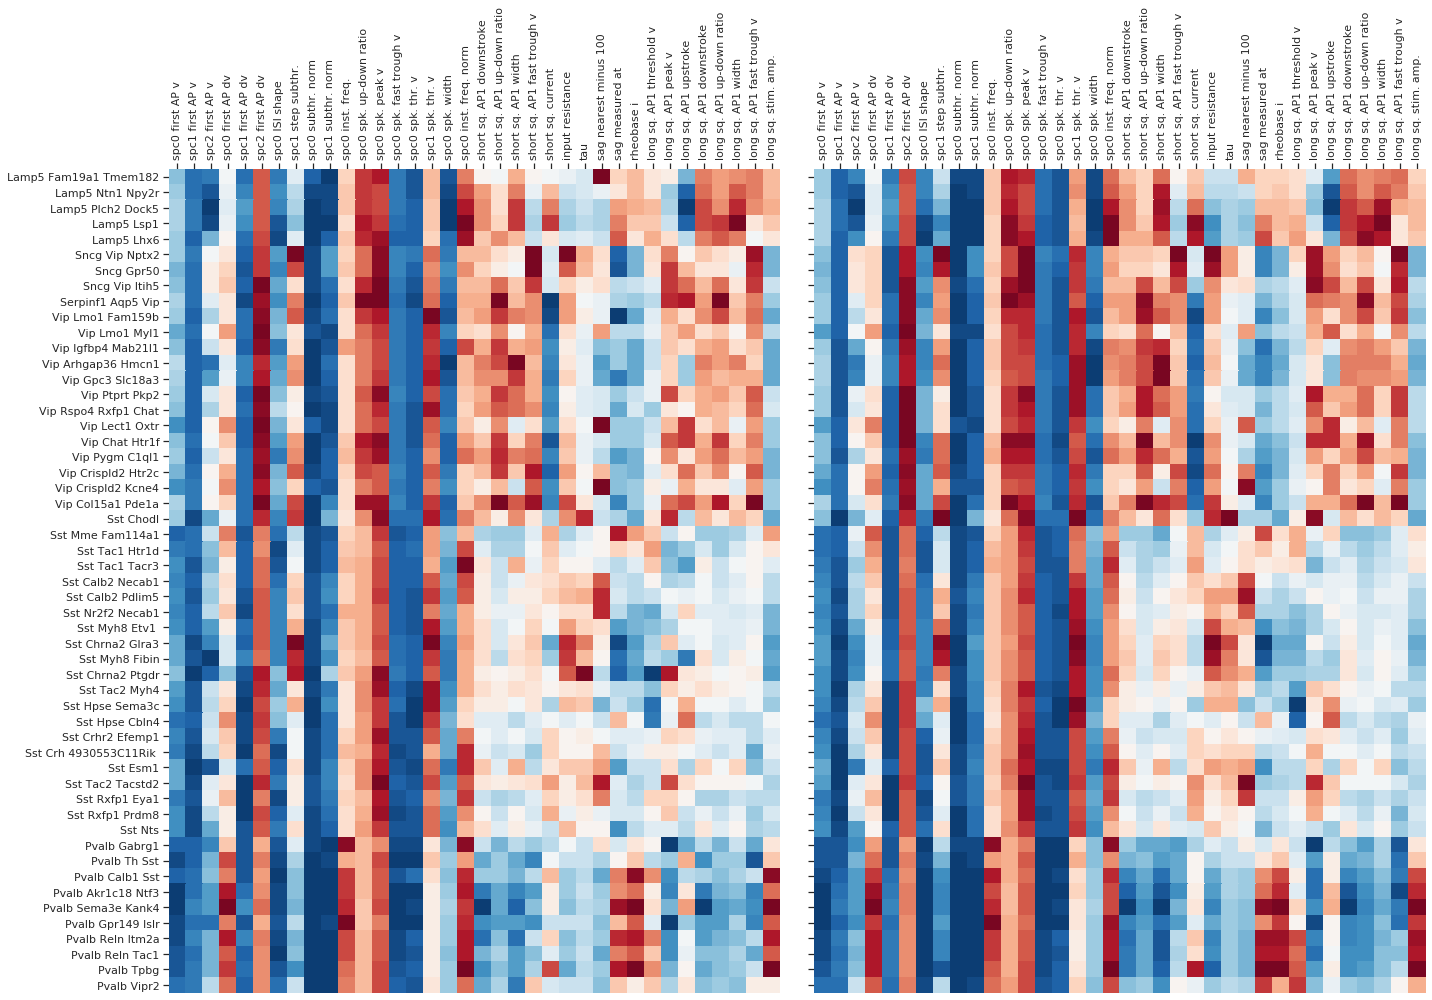

In [15]:
xlabels = O['E_names'][keep_feature_ind]
ylabels = t_types

plt.figure(figsize = (20,14))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40))
cbar_kws={"aspect":30,"shrink":.5,"use_gridspec":False,"location":"right"}
ax = plt.gca()
ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)

ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,cbar=False,cbar_kws=cbar_kws,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(['    ']*len(ylabels),rotation=0)

ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/E_dat_pred.png',dpi=300)

In [16]:
Pearson_R_per_type_T_to_E = []
for i in range(M_true.shape[0]):
    C_ij = np.corrcoef(M_true[i,:],M_pred[i,:])
    Pearson_R_per_type_T_to_E.append(C_ij[0,1])
print(f'Pearson r per type mean: {np.mean(Pearson_R_per_type_T_to_E):0.2f} sd: {np.std(Pearson_R_per_type_T_to_E):0.2f}')

Pearson r per type mean: 0.98 sd: 0.02


In [17]:
for x in zip(t_types,Pearson_R_per_type_E_to_T,Pearson_R_per_type_T_to_E): 
    print(f'{x[0]:25s}  E-->T {x[1]:0.2f}   T-->E {x[2]:0.2f}')

Lamp5 Fam19a1 Tmem182      E-->T 0.83   T-->E 0.96
Lamp5 Ntn1 Npy2r           E-->T 0.92   T-->E 0.99
Lamp5 Plch2 Dock5          E-->T 0.97   T-->E 0.99
Lamp5 Lsp1                 E-->T 0.97   T-->E 1.00
Lamp5 Lhx6                 E-->T 0.80   T-->E 0.96
Sncg Vip Nptx2             E-->T 0.95   T-->E 0.99
Sncg Gpr50                 E-->T 0.89   T-->E 0.99
Sncg Vip Itih5             E-->T 0.96   T-->E 0.99
Serpinf1 Aqp5 Vip          E-->T 0.71   T-->E 0.99
Vip Lmo1 Fam159b           E-->T 0.81   T-->E 0.99
Vip Lmo1 Myl1              E-->T 0.92   T-->E 0.99
Vip Igfbp4 Mab21l1         E-->T 0.81   T-->E 0.97
Vip Arhgap36 Hmcn1         E-->T 0.91   T-->E 0.99
Vip Gpc3 Slc18a3           E-->T 0.90   T-->E 0.99
Vip Ptprt Pkp2             E-->T 0.94   T-->E 1.00
Vip Rspo4 Rxfp1 Chat       E-->T 0.89   T-->E 0.98
Vip Lect1 Oxtr             E-->T 0.84   T-->E 0.98
Vip Chat Htr1f             E-->T 0.95   T-->E 1.00
Vip Pygm C1ql1             E-->T 0.96   T-->E 0.99
Vip Crispld2 Htr2c         E-->

In [18]:
ind_new = R2_E_to_E>0.42
ind_old = R2_T_to_E>0.252
print(f'{np.sum(np.logical_and(ind_new,ind_old))} selected features are the same')

28 selected features are the same
